**NIM : 24/554318/NPA/19979**
**NAMA: PRAMITHA WITAWACITA ASTADEWI**

**DOWNLOAD DATASET DARI KAGLE**

In [13]:
!kaggle datasets download -d warcoder/infant-cry-audio-corpus --force

Dataset URL: https://www.kaggle.com/datasets/warcoder/infant-cry-audio-corpus
License(s): other
  0% 0.00/39.0M [00:00<?, ?B/s]
100% 39.0M/39.0M [00:00<00:00, 512MB/s]


In [5]:
! pip install -q kaggle

In [6]:
 ! mkdir ~/.kaggle

In [7]:
 !cp kaggle.json ~/.kaggle/

In [8]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [11]:
 ! kaggle datasets list

ref                                                                  title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                    Chocolate Sales Data 📊🍫                                  14473  2025-03-19 03:51:40.270000          11110        197  1.0              
abdulmalik1518/mobiles-dataset-2025                                  Mobiles Dataset (2025)                                   20314  2025-02-18 06:50:24.370000          16999        288  1.0              
adilshamim8/student-depression-dataset                               Student Depression Dataset                              467020  2025-03-13 03:12:30.423000           3615      

**EKSTRAK DATASET**

In [14]:
import os,zipfile

In [15]:
os.mkdir('dataset')

In [16]:
dataset_dir = 'dataset'

In [19]:
target_file = 'infant-cry-audio-corpus.zip'

In [20]:
extracting = zipfile.ZipFile(target_file,'r')

In [21]:
Nextracting.extractall(dataset_dir)

In [22]:
extracting.close()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**MASUKAN LIBRARY KE requirements.txt**

In [48]:
pip freeze --local > /content/drive/MyDrive/requirements.txt

**import semua library yang dibutuhkan**

In [23]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

**Fungsi Python untuk ekstraksi ciri suara menggunakan MFCC (Mel-Frequency Cepstral Coefficients)**

In [24]:
# MFCC extraction function
def extract_mfcc(file_path, n_mfcc=100, fixed_length=100):
    try:
        # Read audio file
        y, sr = librosa.load(file_path, sr=None)
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Padding or trimming to a fixed length
        if mfcc.shape[1] < fixed_length:
            pad_width = fixed_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_length]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Evaluation functions

Fungsi: evaluate_model(model, X_test, y_test, class_names)
Parameter:

    model: model machine learning yang sudah dilatih.

    X_test: fitur (data uji).

    y_test: label sebenarnya dari data uji.

    class_names: daftar nama kelas (digunakan untuk label confusion matrix).*


In [25]:
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    metrics = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return metrics


# Feature extraction

Fungsi dari potongan kode di atas adalah untuk mengumpulkan dan mengekstrak fitur suara (MFCC) dari semua file audio .wav yang ada di dalam folder /content/dataset/donateacry_corpus, mengubahnya menjadi array numerik, dan mencatat label berdasarkan nama folder tempat file audio berada.

In [26]:
import os
import librosa
import numpy as np

base_dir = "/content/dataset/donateacry_corpus"

mfcc_list = []
labels = []

fixed_length = 100

for subdir, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            mfcc_features = extract_mfcc(file_path, fixed_length=fixed_length)
            if mfcc_features is not None:
                mfcc_list.append(mfcc_features)
                labels.append(os.path.basename(subdir))

mfcc_array = np.array(mfcc_list)
print(f"MFCC array shape: {mfcc_array.shape}")

MFCC array shape: (457, 100, 100)


# Prepare data

    Tujuan: Menyeimbangkan jumlah sampel antar kelas agar tidak timpang (imbalanced).

    Untuk setiap kelas:

        Cari semua indeks file yang punya label tersebut.

        Pilih acak hingga maksimal 27 sampel dari kelas itu.

        Simpan MFCC-nya dan label-nya.

    Kenapa penting? Agar model tidak berat sebelah ke kelas yang datanya lebih banyak.

In [27]:
# prepare data
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

print(f"Labels shape: {y.shape}")

# Downsample to 27 samples per class
target_samples = 27
downsampled_mfcc_list = []
downsampled_labels = []

for label in np.unique(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    selected_indices = random.sample(indices, min(target_samples, len(indices)))
    downsampled_mfcc_list.extend(mfcc_array[selected_indices])
    downsampled_labels.extend([label] * len(selected_indices))

downsampled_mfcc_array = np.array(downsampled_mfcc_list)
downsampled_labels = np.array(downsampled_labels)

print(f"Downsampled MFCC array shape: {downsampled_mfcc_array.shape}")

X_train, X_test, y_train, y_test = train_test_split(downsampled_mfcc_array, label_encoder.transform(downsampled_labels), test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Labels shape: (457,)
Downsampled MFCC array shape: (102, 100, 100)
X_train shape: (81, 100, 100)
X_test shape: (21, 100, 100)
y_train shape: (81,)
y_test shape: (21,)


Mengubah data ekstraksi fitur MFCC dari bentuk 3 dimensi menjadi 1 dimensi per sample, sehingga dapat digunakan oleh algoritma machine learning klasik seperti Naive Bayes, Random Forest, atau KNN.




In [28]:
n_samples, n_mfcc, n_frames = X_train.shape
X_train_1d = X_train.reshape(n_samples, n_mfcc * n_frames)
X_test_1d = X_test.reshape(X_test.shape[0], n_mfcc * n_frames)

print(f"X_train_1d shape: {X_train_1d.shape}")
print(f"X_test_1d shape: {X_test_1d.shape}")

X_train_2d shape: (81, 10000)
X_test_2d shape: (21, 10000)


Tujuan : Untuk mengecek dan memvisualisasikan distribusi jumlah sample pada masing-masing kelas (label) dalam dataset hasil downsampling.

Total samples: 102
Number of classes: 5
Class distribution:
 - belly_pain: 16
 - burping: 8
 - discomfort: 27
 - hungry: 27
 - tired: 24


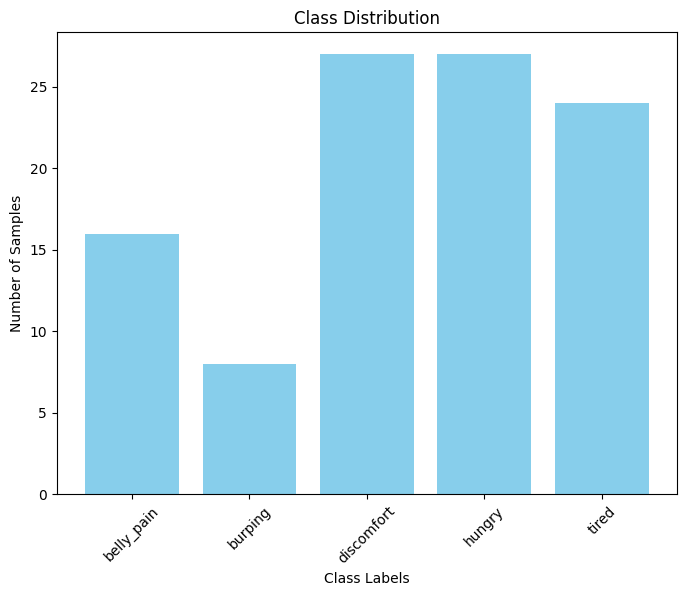

In [29]:
# Print class distributions
print(f"Total samples: {len(downsampled_labels)}")
unique_labels, counts = np.unique(downsampled_labels, return_counts=True)
print(f"Number of classes: {len(unique_labels)}")
print("Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f" - {label}: {count}")

plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Apply the model KNN dan Naive Bayes

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


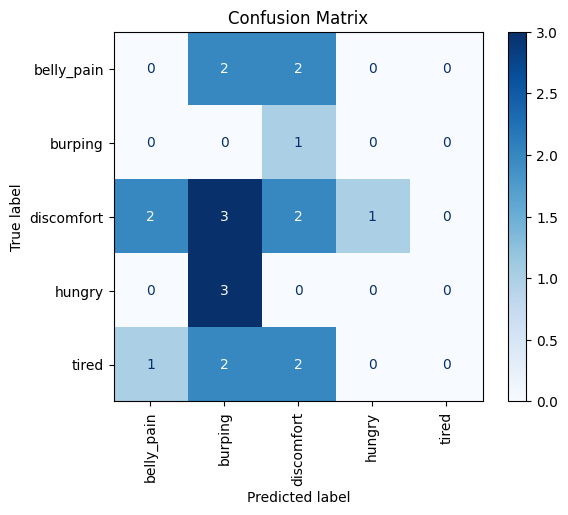

Accuracy: 0.10
Precision: 0.11
Recall: 0.10
F1-Score: 0.10


In [30]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_1d, y_train)
knn_metrics = evaluate_model(knn_model, X_test_1d, y_test, label_encoder.classes_)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


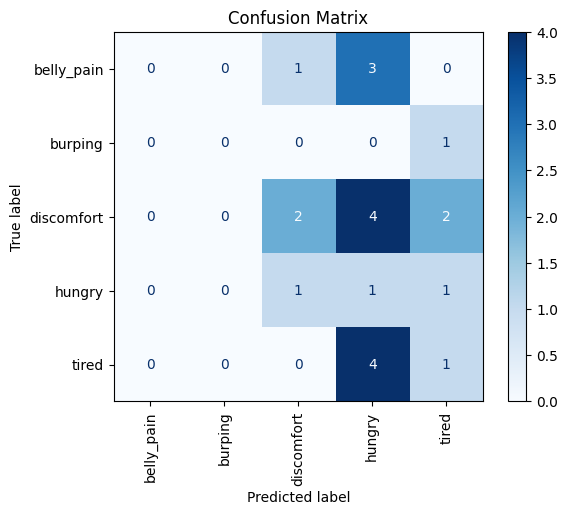

Accuracy: 0.19
Precision: 0.25
Recall: 0.19
F1-Score: 0.19


In [31]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_1d, y_train)
nb_metrics = evaluate_model(nb_model, X_test_1d, y_test, label_encoder.classes_)

Bandingan Hasil Model


In [38]:
results = {
    "KNN": knn_metrics["Accuracy"],
    "Naive Bayes": nb_metrics["Accuracy"],

}

print("\nModel Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.2f}")


Model Comparison:
KNN: 0.10
Naive Bayes: 0.19


Fungsi predict_audio di atas. Fungsi ini digunakan untuk memprediksi kelas dari sebuah file audio .wav menggunakan model machine learning yang sudah dilatih sebelumnya.

In [39]:
def predict_audio(model, file_path, label_encoder, fixed_length=100):
    # Ekstraksi fitur MFCC dari file audio
    mfcc_features = extract_mfcc(file_path, fixed_length=fixed_length)

    if mfcc_features is None:
        print(f"❌ Gagal membaca file: {file_path}")
        return

    # Ubah bentuk fitur agar sesuai dengan model (reshape menjadi 2D)
    mfcc_features = mfcc_features.reshape(1, -1)

    # Prediksi kelas
    predicted_label = model.predict(mfcc_features)[0]

    # Konversi dari angka ke nama label
    predicted_class = label_encoder.inverse_transform([predicted_label])[0]

    print(f"✅ File: {file_path}")
    print(f"🎯 Prediksi Kelas: {predicted_class}")

    return predicted_class


In [42]:
import random

# Pilih suara acak dari dataset untuk diuji
random_folder = random.choice(os.listdir(base_dir))
random_folder_path = os.path.join(base_dir, random_folder)

# Ambil file wav acak dari folder
random_file = random.choice(os.listdir(random_folder_path))
random_file_path = os.path.join(random_folder_path, random_file)

print(f"🔍 File yang diuji: {random_file_path}")


🔍 File yang diuji: /content/dataset/donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav


In [43]:
print("\n🔹 Prediksi dengan KNN:")
predict_audio(knn_model, random_file_path, label_encoder)

print("\n🔹 Prediksi dengan Naive Bayes:")
predict_audio(nb_model, random_file_path, label_encoder)




🔹 Prediksi dengan KNN:
✅ File: /content/dataset/donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav
🎯 Prediksi Kelas: belly_pain

🔹 Prediksi dengan Naive Bayes:
✅ File: /content/dataset/donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav
🎯 Prediksi Kelas: belly_pain


np.str_('belly_pain')

Fungsi atas digunakan untuk membandingkan performa dua model machine learning (dalam hal ini: KNN dan Naive Bayes) berdasarkan metrik Recall dan F1-Score, lalu memvisualisasikannya dalam bentuk grafik batang (bar chart).

Perbandingan Recall dan F1-Score untuk masing-masing model:
KNN => Recall: 0.10, F1-Score: 0.10
Naive Bayes => Recall: 0.19, F1-Score: 0.19


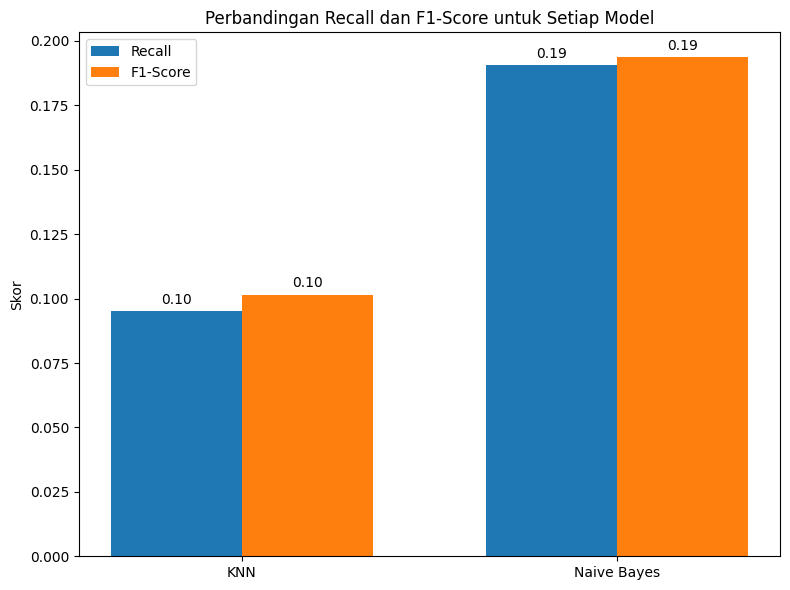

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Misal, knn_metrics, nb_metrics, dan svm_metrics sudah dihitung dengan fungsi evaluate_model sebelumnya

# Mengumpulkan metrik dari setiap model
models = ["KNN", "Naive Bayes"]
recall_scores = [knn_metrics["Recall"], nb_metrics["Recall"]]
f1_scores = [knn_metrics["F1-Score"], nb_metrics["F1-Score"]]

# Menampilkan metrik di konsol
print("Perbandingan Recall dan F1-Score untuk masing-masing model:")
for model, rec, f1 in zip(models, recall_scores, f1_scores):
    print(f"{model} => Recall: {rec:.2f}, F1-Score: {f1:.2f}")

# Visualisasi dalam bentuk grafik batang
x = np.arange(len(models))  # label posisi untuk tiap model
width = 0.35  # lebar batang

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, recall_scores, width, label='Recall')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')

# Tambahkan label, judul, dan keterangan sumbu
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Recall dan F1-Score untuk Setiap Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Menambahkan nilai di atas tiap batang
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # jarak 3 titik ke atas
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()
